In [1]:
import numpy as np
import torch
from torch import nn
%matplotlib notebook

import qucumber
from qucumber.nn_states import PositiveWaveFunction
from qucumber.callbacks import MetricEvaluator, LivePlotting
from qucumber.utils.data import load_data
from qucumber.utils import training_statistics as ts

from masked_rbm import MaskedBinaryRBM

qucumber.set_random_seed(161)

In [2]:
data, psi = load_data("../../QuCumber/examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_data.txt", 
                      "../../QuCumber/examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_psi.txt")

In [3]:
nn_state = PositiveWaveFunction(10, 10, gpu=False)
space = nn_state.generate_hilbert_space()
init_params = {k: v.clone() for k, v in nn_state.rbm_am.named_parameters()}  # save the initial weights for later

In [4]:
me = MetricEvaluator(50, {"fidelity": ts.fidelity}, 
                     target_psi=psi, verbose=True, space=space)
lp = LivePlotting(50, me, "fidelity")
cbs = [me, lp]

We begin by training the unmasked model for 500 epochs to create a mask.

<IPython.core.display.Javascript object>


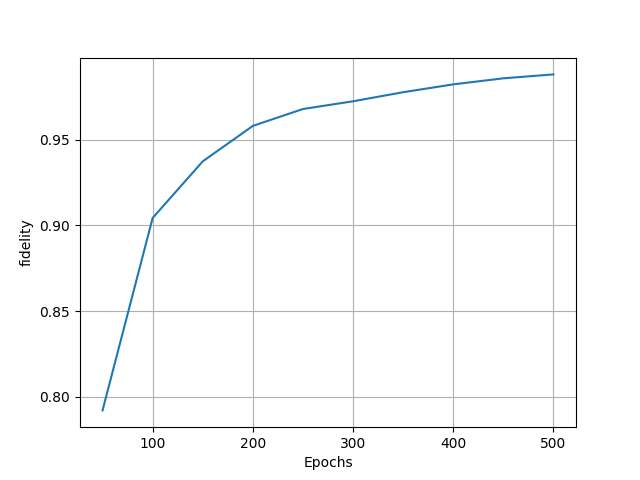

Epoch: 50	fidelity = 0.792118
Epoch: 100	fidelity = 0.904313
Epoch: 150	fidelity = 0.937336
Epoch: 200	fidelity = 0.958010
Epoch: 250	fidelity = 0.967849
Epoch: 300	fidelity = 0.972355
Epoch: 350	fidelity = 0.977644
Epoch: 400	fidelity = 0.982219
Epoch: 450	fidelity = 0.985747
Epoch: 500	fidelity = 0.988031



In [5]:
me.clear_history()  # clear the callback's internal history
nn_state.fit(data, lr=0.01, epochs=500, progbar="notebook", callbacks=cbs)

In [6]:
# mask 50% of the weights which have smallest magnitudes
masks = {k: MaskedBinaryRBM.create_mask(v, p=0.5) for k, v in nn_state.rbm_am.named_parameters()}
rbm = MaskedBinaryRBM(init_params, masks, gpu=False)

In [7]:
nn_state2 = PositiveWaveFunction(10, 10, gpu=False, module=rbm)

<IPython.core.display.Javascript object>


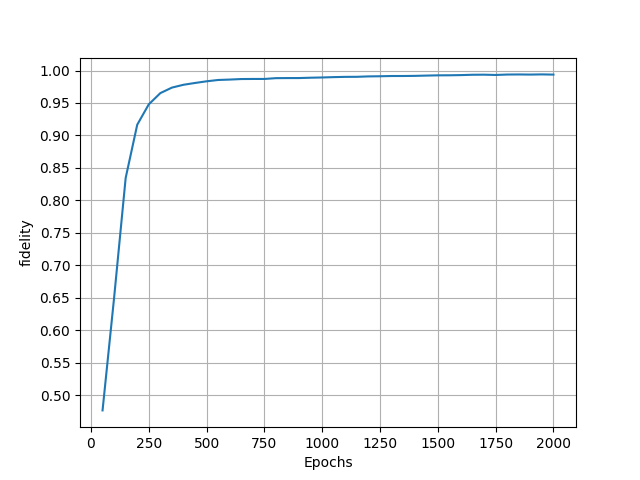

Epoch: 50	fidelity = 0.476748
Epoch: 100	fidelity = 0.650215
Epoch: 150	fidelity = 0.834613
Epoch: 200	fidelity = 0.916550
Epoch: 250	fidelity = 0.947965
Epoch: 300	fidelity = 0.965222
Epoch: 350	fidelity = 0.973701
Epoch: 400	fidelity = 0.978057
Epoch: 450	fidelity = 0.980836
Epoch: 500	fidelity = 0.983402
Epoch: 550	fidelity = 0.985436
Epoch: 600	fidelity = 0.986067
Epoch: 650	fidelity = 0.986876
Epoch: 700	fidelity = 0.987009
Epoch: 750	fidelity = 0.987009
Epoch: 800	fidelity = 0.988250
Epoch: 850	fidelity = 0.988368
Epoch: 900	fidelity = 0.988404
Epoch: 950	fidelity = 0.988923
Epoch: 1000	fidelity = 0.989299
Epoch: 1050	fidelity = 0.989839
Epoch: 1100	fidelity = 0.990230
Epoch: 1150	fidelity = 0.990309
Epoch: 1200	fidelity = 0.990942
Epoch: 1250	fidelity = 0.991167
Epoch: 1300	fidelity = 0.991548
Epoch: 1350	fidelity = 0.991557
Epoch: 1400	fidelity = 0.991750
Epoch: 1450	fidelity = 0.992199
Epoch: 1500	fidelity = 0.992579
Epoch: 1550	fidelity = 0.992662
Epoch: 1600	fidelity = 0.992

In [8]:
me.clear_history()
nn_state2.fit(data, lr=0.01, epochs=2000, progbar="notebook", callbacks=cbs)

Note that at the 500th epoch, the fidelity is already higher than that of the original (unmasked) model at the same epoch. We let the model train further just to make sure the fidelity doesn't plateau, and to see how well the training converges. I found that fidelity does start plateau-ing earlier than 99% fidelity when more than 70% of the weights are being pruned. 65% pruning gave a plateau around 99.2% fidelity, 70% pruning gave a plateau around 97.5% fidelity, 80% pruning plateau'd around 86% fidelity, 90% pruning plateau'd around 57% fidelity.

Next, we check the fidelity of the masked model when its weights are set to their initial values. We don't worry about the biases as they are, by default, set to 0 upon initialization of the model.

In [10]:
nn_s = PositiveWaveFunction(10,10,gpu=False)
nn_s.rbm_am.weights = nn.Parameter(init_params["weights"].clone() * masks["weights"])

In [11]:
ts.fidelity(nn_s, psi, space)

0.4498844459933284

Compare to the fidelity of a model with identical initial parameters, but with no masking applied:

In [12]:
nn_s_unmasked = PositiveWaveFunction(10,10,gpu=False)
nn_s_unmasked.rbm_am.weights = nn.Parameter(init_params["weights"].clone())
ts.fidelity(nn_s_unmasked, psi, space)

0.4262501000717602

We see that masking improves the initial model. Lastly, we will train this model for 2000 epochs to compare the performance of the masked model.

<IPython.core.display.Javascript object>


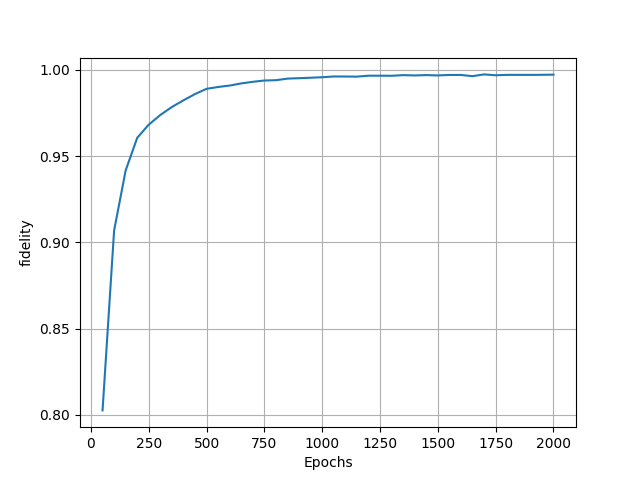

Epoch: 50	fidelity = 0.802655
Epoch: 100	fidelity = 0.906845
Epoch: 150	fidelity = 0.941665
Epoch: 200	fidelity = 0.960559
Epoch: 250	fidelity = 0.968204
Epoch: 300	fidelity = 0.973770
Epoch: 350	fidelity = 0.978408
Epoch: 400	fidelity = 0.982274
Epoch: 450	fidelity = 0.985890
Epoch: 500	fidelity = 0.988933
Epoch: 550	fidelity = 0.989988
Epoch: 600	fidelity = 0.990820
Epoch: 650	fidelity = 0.992050
Epoch: 700	fidelity = 0.992982
Epoch: 750	fidelity = 0.993724
Epoch: 800	fidelity = 0.993916
Epoch: 850	fidelity = 0.994836
Epoch: 900	fidelity = 0.995080
Epoch: 950	fidelity = 0.995350
Epoch: 1000	fidelity = 0.995625
Epoch: 1050	fidelity = 0.996065
Epoch: 1100	fidelity = 0.996047
Epoch: 1150	fidelity = 0.995977
Epoch: 1200	fidelity = 0.996520
Epoch: 1250	fidelity = 0.996515
Epoch: 1300	fidelity = 0.996477
Epoch: 1350	fidelity = 0.996836
Epoch: 1400	fidelity = 0.996665
Epoch: 1450	fidelity = 0.996872
Epoch: 1500	fidelity = 0.996672
Epoch: 1550	fidelity = 0.996958
Epoch: 1600	fidelity = 0.996

In [13]:
me.clear_history()
nn_s.fit(data, lr=0.01, epochs=2000, progbar="notebook", callbacks=cbs)

At epoch 2000, the unmasked model seems to have won out slightly, but the fidelities are too close together to make any solid conclusion. If we consider that the mask required 500 training epochs to produce, it makes more sense to compare the 1500th epoch of the masked model to the 2000th epoch of the unmasked. These two values are still relatively close together. Due to the closeness of the fidelities, it doesn't really make much sense to draw conclusions on each model's relative performance from these figures. Indeed, with the right random seed, the masked model sometimes wins out. 

We *can*, however, conclude that even with only half the number of weights, the RBM is still able to reconstruct the desired wavefunction with about the same accuracy.